### โค้ดไพทอนประกอบบทที่ 6 ของหนังสือ 
### "การโปรแกรมไพทอนสำหรับงานควบคุมและฝังตัว"
### ดร.วโรดม ตู้จินดา

<a href="https://colab.research.google.com/github/dewdotninja/py4conemb/blob/master/code/chapter6/notebook/chapter6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## หากรันใน colab หรือยังไม่มีไลบรารี Python control library  ต้องติดตั้งก่อนโดยรันเซลล์นี้
!pip install control

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import control as ctl

In [3]:
class Students:
    def __init__(self, name, surname, student_id, gender):
        self.name = name
        self.surname = surname
        self.sid = student_id
        self.gender = gender
        
    def greet(self):
        print("Hello, my name is "+self.name+" "+self.surname)
        

In [4]:
student1 = Students("Nongporn","Hubbard","6610514774","female")

In [5]:
student1.greet()

Hello, my name is Nongporn Hubbard


In [6]:
class iupStudents(Students):
    def greet(self):
        print("Hello, my name is "+self.surname+", "+self.name)        

In [7]:
student2 = iupStudents("Brad","Pitbull","6615512987","male")
student2.greet()

Hello, my name is Pitbull, Brad


In [8]:
class iupStudents(Students):
    def __init__(self,name,surname,student_id,gender,nationality):
        super().__init__(name,surname,student_id,gender)
        self.nationality = nationality
    def greet(self):
        print("Hello, my name is "+self.surname+", "+self.name)
        print("I am from "+ self.nationality)        

In [9]:
student3 = iupStudents("Hermione","Granger","6615513184","female","UK")
student3.greet()

Hello, my name is Granger, Hermione
I am from UK


In [10]:
# Ex 6.3

In [11]:
km = 100  # torque constant
kb = 1  # back EMF constant
k = 1000 # torsional stiffness of harmonic drive
r = 10   # gear ratio
R = 1  # armature resistance
L = 0.1 # armature inductance
Jm = 1  #  motor inertia
Bm = 0.01  # motor shaft friction
Jl = 3  # load inertia
Bl = 0.05  # load friction
s = ctl.tf("s")
pl = Jl*s**2 + Bl*s + k
pm = Jm*s**2 + Bm*s + k
P = km*k/(pm*pl*(L*s+R) - k**2*(L*s+R) + r*km*kb*s*pl)
P

TransferFunction(array([100000]), array([3.00000000e-01, 3.00800000e+00, 3.40008005e+03, 4.05600050e+03,
       1.00006000e+06, 0.00000000e+00]))

In [12]:
P_inner = ctl.minreal(s*P)
P_inner

1 states have been removed from the model


TransferFunction(array([333333.33333333]), array([1.00000000e+00, 1.00266667e+01, 1.13336002e+04, 1.35200017e+04,
       3.33353333e+06]))

In [13]:
P_outer = 1/s

In [14]:
# PID controller class
class PID:
    def __init__(self,kp,ki,kd,n,ts):
        # PID parameters
        self.kp = kp
        self.ki = ki
        self.kd = kd
        self.n = n
        self.ts = ts
        
        # controller states
        self.e1 = 0
        self.e0 = 0
        self.up0 = 0
        self.ui1 = 0
        self.ui0 = 0
        self.ud1 = 0
        self.ud0 = 0
        self.cd0 = 0  # coefficients for derivative output
        self.cd1 = 0
        self.update()
        
    # parameter getters & setters 
    def getkp(self):
        return self.kp
    def getki(self):
        return self.ki
    def getkd(self):
        return self.kd
    def getn(self):
        return self.n
    def getts(self):
        return self.ts
    def getparms(self):
        parms = np.array([self.kp,self.ki,self.kd,self.n,self.ts])
        return parms

    def setkp(self,kp):
        self.kp = kp
    def setki(self,ki):
        self.ki = ki
    def setkd(self,kd):
        self.kd = kd
    def setn(self,n):
        self.n = n
    def setts(self,ts):
        self.ts = ts
    def setparms(self,parms):
        self.kp = parms[0]
        self.ki = parms[1]
        self.kd = parms[2]
        self.n = parms[4]
        self.ts = parms[7]

    def update(self): # coefficient update
        self.cd0 = -(self.n*self.ts -2)/(2+self.n*self.ts)
        self.cd1 = 2*self.kd*self.n/(2+self.n*self.ts)
        
    # reset controller states
    def reset(self):
        self.e1 = 0
        self.e0 = 0
        self.up0 = 0
        self.ui1 = 0
        self.ui0 = 0
        self.ud1 = 0
        self.ud0 = 0
        self.u = 0

    def out(self,r,y):
        # state transfer
        self.e1 = self.e0
        
        self.ui1 = self.ui0
        self.ud1 = self.ud0
        # compute errors for each term
        self.e0 = r - y
        
        self.up0 = self.kp*self.e0 # output of P term
        self.ui0 = self.ui1 +0.5*self.ki*self.ts*(self.e0+self.e1) # output of I term
        self.ud0 = self.cd0*self.ud1 +self.cd1*(self.e0 - self.e1) # output of D term
        self.u = self.up0 + self.ui0 + self.ud0        
        return self.u

In [15]:
Ts = 0.001 # sampling period


In [16]:
Kp1 = 7 #5
Ki1 = 0.8
Kd1 = 3 #2.5 
N1 = 20
Kp2 = 1.6
Ki2 = 1.3
Kd2 = 0.1
N2 = 20

In [17]:
# create PID instances for inner and outer loops
pid_inner = PID(Kp1,Ki1,Kd1,N1,Ts)
pid_outer = PID(Kp2,Ki2,Kd2,N2,Ts)

For plant simulation, we define the class as in https://github.com/dewdotninja/control_python/blob/main/discrete_implement_oop.ipynb

In [18]:
class DF2:
    def __init__(self,num,den,ts):
        self.num = num
        self.den = den
        self.ts = ts  # keep sampling time for reference only.
        self.order = len(self.den)
        self.states = np.zeros((self.order,1))
        self.y = 0.0
        
    def state_update(self): # update state vectors
        for k in range(self.order-1):
            self.states[self.order-k-1] = self.states[self.order-k-2]
    
    def reset(self):
        for k in range(self.order-1):
            self.states[k] = 0.0
    
    def out(self, u): # compute output
        self.states[0] = u
        y = self.num[0]*u
        for k in range(self.order-1):
            self.states[0] = self.states[0] -self.den[k+1]*self.states[k+1]
            y = y + (self.num[k+1] - self.num[0]*self.den[k+1])*self.states[k+1]   
        return y
        

In [19]:
Pd_inner = ctl.sample_system(P_inner, Ts, method='tustin')
Pdnum_inner, Pdden_inner = ctl.tfdata(Pd_inner)
pnum_inner = np.squeeze(np.array(Pdnum_inner))
pden_inner = np.squeeze(np.array(Pdden_inner))

In [20]:
Pd_outer = ctl.sample_system(P_outer, Ts, method='tustin')
Pdnum_outer, Pdden_outer = ctl.tfdata(Pd_outer)
pnum_outer = np.squeeze(np.array(Pdnum_outer))
pden_outer = np.squeeze(np.array(Pdden_outer))

In [21]:
p_inner = DF2(pnum_inner,pden_inner,Ts)
p_outer = DF2(pnum_outer,pden_outer,Ts)

In [22]:
# continuouse PID function
def PID_ct(kp, ki,kd,N):
    s = ctl.tf("s")
    C = kp + ki/s + kd*s*N/(s+N)
    return C

In [23]:
# for comparison purpose
C_pid_inner = PID_ct(Kp1,Ki1,Kd1,N1)
L_inner = C_pid_inner*P_inner
T_inner = ctl.feedback(L_inner)
C_pid_outer = PID_ct(Kp2,Ki2,Kd2,N2)
L_outer = C_pid_outer*T_inner*P_outer
T_outer = ctl.minreal(ctl.feedback(L_outer))

0 states have been removed from the model


In [24]:
tvec = np.arange(0,20,Ts)
tv, yc = ctl.step_response(T_outer,tvec) # used for comparison
rvec = np.ones(tvec.shape)
yvec = np.zeros(tvec.shape)

In [25]:
pid_inner.reset()
pid_outer.reset()
p_inner.reset()
p_outer.reset()

co_inner = 0
co_outer = 0
po_inner = 0
po_outer = 0
for i in range(len(tvec)):
    # state updates
    p_inner.state_update()
    p_outer.state_update()
        
    co_outer = pid_outer.out(rvec[i],po_outer)    
    co_inner = pid_inner.out(co_outer,po_inner)    
    po_inner = p_inner.out(co_inner)
    po_outer = p_outer.out(po_inner)

    yvec[i] = po_outer

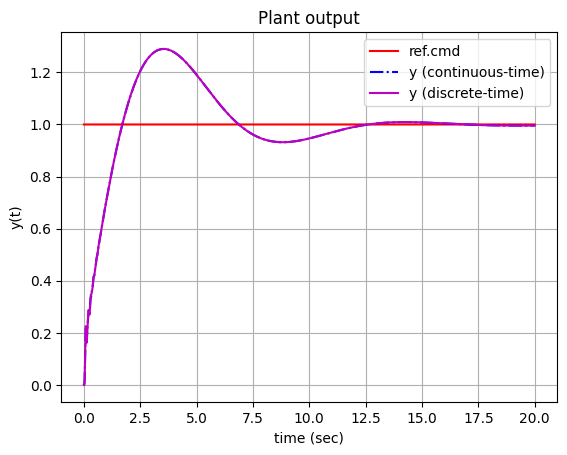

In [26]:
plt.figure()
plt.plot(tvec,rvec,'r-',tvec, yc,'b-.',tvec,yvec,'m-')
plt.grid('True')
plt.xlabel('time (sec)')
plt.ylabel('y(t)')
plt.legend(['ref.cmd','y (continuous-time)','y (discrete-time)'])
plt.title("Plant output")
plt.show()

In [27]:
# Problem sets: command generator
# Use plant from ex 6.3 above

In [28]:
# class simple derivative
class DERIVATIVE():
    def __init__(self,T):
        self.reset()
        self.T = T
    def reset(self):
        self.dx = 0.0
        self.x0 = 0.0
        self.x1 = 0.0
    def out(self,x):
        self.x1 = self.x0
        self.x0 = x
        self.dx = (self.x0-self.x1)/self.T
        return self.dx
    def sett(self,T):
        self.T = T
        

In [29]:
ydot = DERIVATIVE(Ts)
ydotdot = DERIVATIVE(Ts)

In [30]:
ysin = np.sin(tvec)

In [31]:
yd = np.zeros(tvec.shape)
ydd = np.zeros(tvec.shape)

In [32]:
# test
ydot.reset()
ydotdot.reset()
for i in range(len(tvec)):
    yd[i] = ydot.out(ysin[i]) 
for i in range(len(tvec)):
    ydd[i] = ydotdot.out(yd[i]) 
    

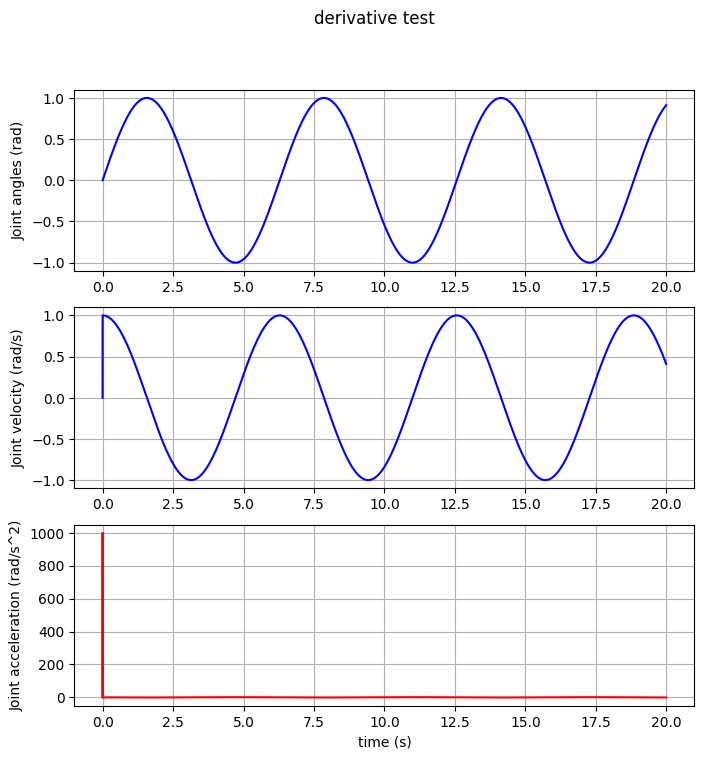

In [33]:
# Plot the trajectory
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(8,8))
fig.suptitle('derivative test')
ax1.plot(tvec,ysin,'b-')
ax1.grid(True)
ax1.set_ylabel('Joint angles (rad)')

ax2.plot(tvec,yd,'b-')
ax2.grid(True)
ax2.set_ylabel('Joint velocity (rad/s)')

ax3.plot(tvec,ydd,'r-')
ax3.set_xlabel('time (s)')
ax3.set_ylabel('Joint acceleration (rad/s^2)')
ax3.grid(True)

In [34]:
ydd[0] = ydd[1] = 0

In [35]:
class CPOLY:
    def __init__(self):
        self.a0 = 0.0
        self.a1 = 0.0
        self.a2 = 0.0
        self.a3 = 0.0
        self.T = 0.01 
        self.tf = 1.0
        self.cnts = 0
    def retrieve_cnts(self):
        return self.cnts
    def reset_cnts(self):
        self.cnts = 0
    def compute_coeff(self,q0,qf,T,numpts):
        #  t0 = 0, tf = T*numpts
        self.T = T
        self.tf = self.T*numpts
        qdist = qf - q0
        self.a0 = q0
        self.a1 = 0.0
        self.a2 = 3*qdist/(self.tf**2)
        self.a3 = -2*qdist/(self.tf**3)    
    def generate(self,t): # generate joint angle
        q = self.a0 + self.a2*t**2 + self.a3*t**3
        qd = 2*self.a2*t +3*self.a3*t**2
        qdd = 2*self.a2 +6*self.a3*t
        self.cnts+=1
        return q, qd, qdd

In [36]:
tvec = np.arange(0,20,Ts)
qrvec = np.ones(tvec.shape)
qdrvec = np.ones(tvec.shape)
qddrvec = np.ones(tvec.shape)
qvec = np.zeros(tvec.shape)
#qdvec = np.zeros(tvec.shape)
#qddvec = np.zeros(tvec.shape)

In [37]:
len(tvec)

20000

In [38]:
cpoly = CPOLY()
datapts = len(tvec)
cpoly.compute_coeff(0,np.pi,Ts,datapts)

In [39]:
pid_inner.reset()
pid_outer.reset()
p_inner.reset()
p_outer.reset()
cpoly.reset_cnts()
co_inner = 0
co_outer = 0
po_inner = 0
po_outer = 0
for i in range(len(tvec)):
    tstep = i*Ts
    # state updates
    p_inner.state_update()
    p_outer.state_update()
    q,qd,qdd = cpoly.generate(tstep)
    qrvec[i] = q
    qdrvec[i] = qd
    qddrvec[i] = qdd
    co_outer = pid_outer.out(q,po_outer)    
    co_inner = pid_inner.out(co_outer,po_inner)    
    po_inner = p_inner.out(co_inner)
    po_outer = p_outer.out(po_inner)
    qvec[i] = po_outer

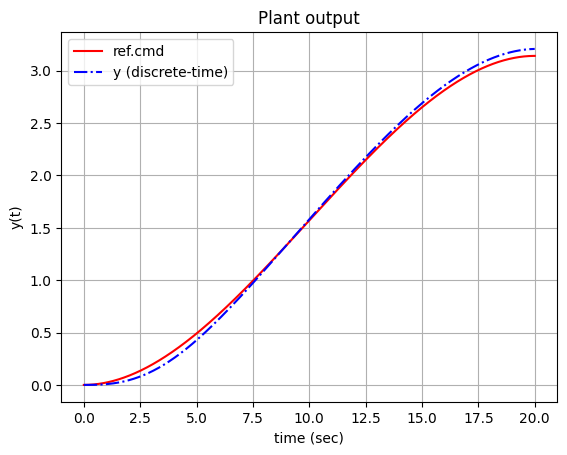

In [40]:
plt.figure()
plt.plot(tvec,qrvec,'r-',tvec, qvec,'b-.')
plt.grid('True')
plt.xlabel('time (sec)')
plt.ylabel('y(t)')
plt.legend(['ref.cmd','y (discrete-time)'])
plt.title("Plant output")
plt.show()

In [41]:
qdot = DERIVATIVE(Ts)
qdotdot = DERIVATIVE(Ts)
qd = np.zeros(tvec.shape)
qdd = np.zeros(tvec.shape)

In [42]:
qdot.reset()
qdotdot.reset()
for i in range(len(tvec)):
    qd[i] = qdot.out(qvec[i]) 
for i in range(len(tvec)):
    qdd[i] = qdotdot.out(qd[i]) 
    

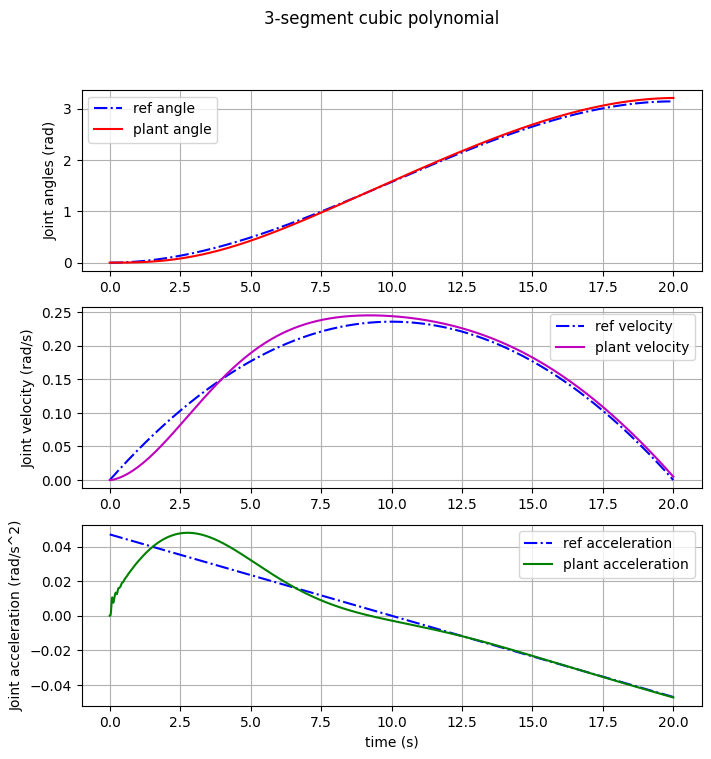

In [44]:
# Plot the trajectory
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(8,8))
fig.suptitle('3-segment cubic polynomial')
ax1.plot(tvec,qrvec,'b-.',tvec,qvec,'r-')
ax1.grid(True)
ax1.legend(['ref angle','plant angle'])
ax1.set_ylabel('Joint angles (rad)')

ax2.plot(tvec,qdrvec,'b-.',tvec,qd,'m-')
ax2.grid(True)
ax2.set_ylabel('Joint velocity (rad/s)')
ax2.legend(['ref velocity','plant velocity'])

ax3.plot(tvec,qddrvec,'b-.',tvec,qdd,'g-')
ax3.set_xlabel('time (s)')
ax3.set_ylabel('Joint acceleration (rad/s^2)')
ax3.legend(['ref acceleration','plant acceleration'])
ax3.grid(True)


In [45]:
class QPOLY(CPOLY):
    def __init__(self):
        super().__init__()
        self.a4 = 0.0
        self.a5 = 0.0 
    def compute_coeff(self,q0,qf,T,numpts):
        #  t0 = 0, tf = T*numpts
        self.T = T
        self.tf = self.T*numpts
        qdist = qf - q0
        self.a0 = q0
        self.a1 = 0.0
        self.a2  = 0.0
        self.a3 = 10*qdist/(self.tf**3)
        self.a4 = -15*qdist/(self.tf**4)
        self.a5 = 6*qdist/(self.tf**5)
    def generate(self,t): # generate joint angle
        q = self.a0 + self.a3*t**3 + self.a4*t**4 + self.a5*t**5
        qd = self.a1+2*self.a2*t+3*self.a3*t**2 + 4*self.a4*t**3 + 5*self.a5*t**4
        qdd = 2*self.a2+6*self.a3*t + 12*self.a4*t**2 + 20*self.a5*t**3
        self.cnts+=1
        return q, qd, qdd

In [46]:
qpoly = QPOLY()
qpoly.compute_coeff(0,np.pi,Ts,datapts)

In [49]:
pid_inner.reset()
pid_outer.reset()
p_inner.reset()
p_outer.reset()
qpoly.reset_cnts()
co_inner = 0
co_outer = 0
po_inner = 0
po_outer = 0
for i in range(len(tvec)):
    tstep = i*Ts
    # state updates
    p_inner.state_update()
    p_outer.state_update()
    q,qd,qdd = qpoly.generate(tstep)
    qrvec[i] = q
    qdrvec[i] = qd
    qddrvec[i] = qdd
    co_outer = pid_outer.out(q,po_outer)    
    co_inner = pid_inner.out(co_outer,po_inner)    
    po_inner = p_inner.out(co_inner)
    po_outer = p_outer.out(po_inner)
    qvec[i] = po_outer

In [50]:
qdvec = np.zeros(tvec.shape)
qddvec = np.zeros(tvec.shape)

In [51]:
qdot.reset()
qdotdot.reset()
for i in range(len(tvec)):
    qdvec[i] = qdot.out(qvec[i]) 
for i in range(len(tvec)):
    qddvec[i] = qdotdot.out(qdvec[i]) 
    

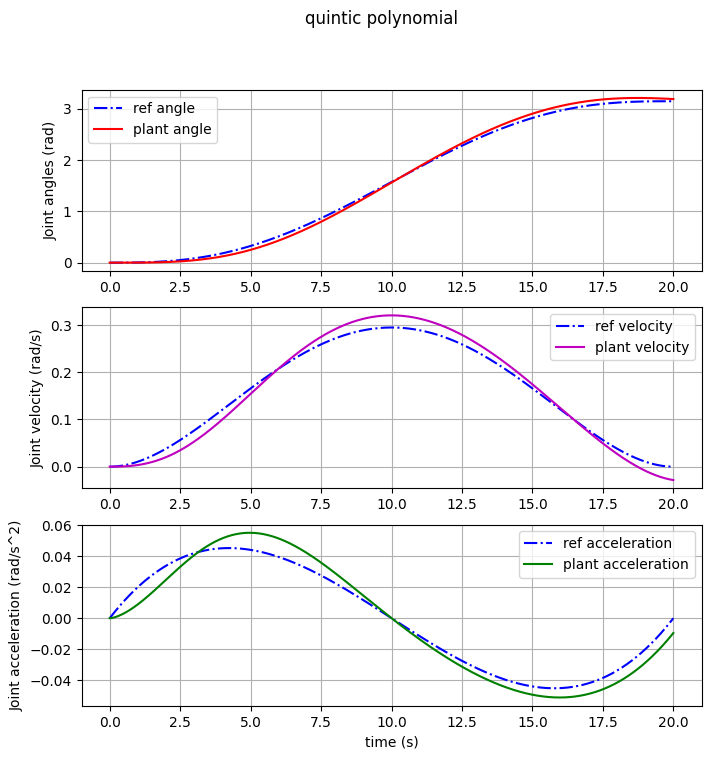

In [52]:
# Plot the trajectory
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(8,8))
fig.suptitle('quintic polynomial')
ax1.plot(tvec,qrvec,'b-.',tvec,qvec,'r-')
ax1.grid(True)
ax1.legend(['ref angle','plant angle'])
ax1.set_ylabel('Joint angles (rad)')

ax2.plot(tvec,qdrvec,'b-.',tvec,qdvec,'m-')
ax2.grid(True)
ax2.set_ylabel('Joint velocity (rad/s)')
ax2.legend(['ref velocity','plant velocity'])

ax3.plot(tvec,qddrvec,'b-.',tvec,qddvec,'g-')
ax3.set_xlabel('time (s)')
ax3.set_ylabel('Joint acceleration (rad/s^2)')
ax3.legend(['ref acceleration','plant acceleration'])
ax3.grid(True)


In [ ]:
# integrator class

In [1]:
class INTEGRATOR:
    def __init__(self, T):
        self.reset()
        self.T = T
    def reset(self):
        self.u0 = 0.0 
        self.u1 = 0.0
        self.y0 = 0.0
        self.y1 = 0.0   
    def out(self, u):
        self.u1 = self.u0
        self.y1 = self.y0
        self.u0 = u
        y0 = self.y1 + 0.5*self.T*(self.u0+self.u1)
        self.y0 = y0
        return y0
    def sett(self, T):
        self.T = T

In [2]:
Ts = 0.001 
Int1 = INTEGRATOR(Ts)

In [5]:
tvec = np.arange(0,20,Ts)
u = np.sin(tvec)
y = np.zeros(tvec.shape)

In [6]:
Int1.reset()
for i in range(len(tvec)):
    y[i] = Int1.out(u[i]) 

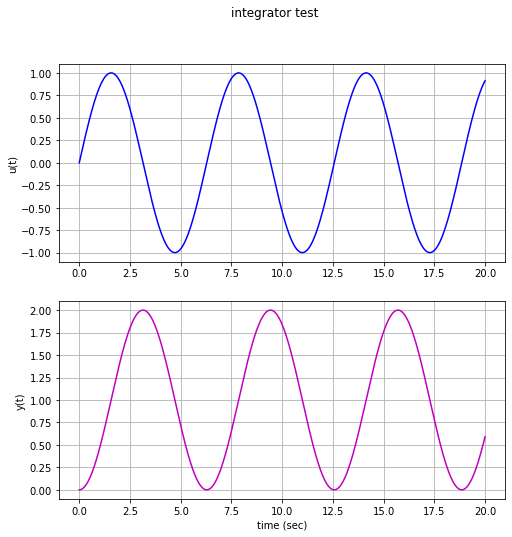

In [8]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(8,8))
fig.suptitle('integrator test')
ax1.plot(tvec,u,'b-')
ax1.grid(True)
ax1.set_ylabel('u(t)')

ax2.plot(tvec,y,'m-')
ax2.grid(True)
ax2.set_ylabel('y(t)')
ax2.set_xlabel('time (sec)')
plt.show()